# Проект для "Викишоп" с BERT

In [1]:

#!pip install nltk
#!pip install torch torchvision torchaudio

In [2]:
#!pip install tensorflow-text

In [3]:
#!pip install -q tf-models-official

In [4]:
#!pip install transformers

In [5]:
import os
import pandas as pd
import re
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import torch
if torch.cuda.is_available():
    print("PyTorch c GPU")
else:
    print("PyTorch c CPU")
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

import transformers
from transformers import BertTokenizer, BertForSequenceClassification #, TFBertForSequenceClassification

import matplotlib.pyplot as plt

import time
import timeit
from datetime import datetime
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")

PyTorch c GPU


In [6]:
RS = 8888 # random state
POROG_TEST = 0.75 # пороговое значение метрики f1 заказчика

## 1. Изучение и предобработка данных

In [7]:
# Загружаем данные
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'

if os.path.exists(pth1):
    rawcorpus = pd.read_csv(pth1)
    
elif os.path.exists(pth2):
    rawcorpus = pd.read_csv(pth2)
    
else:
    print('Ошибка загрузки данных, проверьте правильность пути, наличие файла')

In [8]:
display(rawcorpus.head(10), rawcorpus.tail())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


Неинформативная колонка Unnamed: 0

In [9]:
# Общая информация
rawcorpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [10]:
# Фильтруем неинформативные колонки
rawcorpus = rawcorpus[['text','toxic']]

In [11]:
# Проверяем наличие явных дубликотов
rawcorpus[rawcorpus.duplicated()]

,text,toxic


Явных дубликотов нет.

In [12]:
# Получаем список не обработанных текстов
raw_tweets = [tweet for tweet in rawcorpus['text']]

In [13]:
raw_tweets

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

В данном корпусе текстов содержится много символов не являющимися словами, символы разных кодировок, управляющие символы итп, отфильтруем данные тексты.

In [14]:
# Функция анализа корпуса текстов на количество слов в каждом тексте
def DescribeCorpus(corpus):
    t = pd.DataFrame(corpus, columns=['text'])
    t['words'] = t['text'].str.split(' ')
    t['word_count'] = t['words'].apply(lambda x: len(x))
    display(t['word_count'].describe())
    display(t.head())

In [15]:
# Проанализируем необработанный корпус текстов на количество токенов в каждом тексте
DescribeCorpus(raw_tweets)

count    159292.000000
mean         67.807348
std         100.427397
min           1.000000
25%          17.000000
50%          36.000000
75%          76.000000
max        2273.000000
Name: word_count, dtype: float64

,text,words,word_count
0,Explanation\nWhy the edits made under my usern...,"[Explanation\nWhy, the, edits, made, under, my...",42
1,D'aww! He matches this background colour I'm s...,"[D'aww!, He, matches, this, background, colour...",18
2,"Hey man, I'm really not trying to edit war. It...","[Hey, man,, I'm, really, not, trying, to, edit...",42
3,"""\nMore\nI can't make any real suggestions on ...","[""\nMore\nI, can't, make, any, real, suggestio...",112
4,"You, sir, are my hero. Any chance you remember...","[You,, sir,, are, my, hero., Any, chance, you,...",13


Максимальное количество слов в строке до предобработки 2273.  
75% квантиль при этом равен 76 словам.

In [16]:
# урезаем объем данных, так как на платформе яндекс сильно ограничены ресурсы,
# все вычисления на k8s происходят на процессоре с сильно ограниченным процессорным временем
# и с ограничениями по памяти.
rawcorpus = rawcorpus.head(25000)

In [17]:
# Загрузка токенизатора
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Функция предобарботки текста
def preprocess_text(text):
    # Удаление ссылок и упоминаний (@username)
    text = re.sub(r'@\w+', '', text)

    # Удаление символов кирилицы, китайского и других символов, кроме латиницы и цифр
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Удаление знаков препинания и специальных символов
    text = re.sub(r'[^\w\s]', '', text)
    
    # Удаление URL, начинающихся с http:// или https://
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

    # Приведение всех букв к нижнему регистру
    text = text.lower()

    # Токенизация текста
    tokens = nltk.word_tokenize(text)

    # Удаление стоп-слов
    tokens = [token for token in tokens if token not in stop_words]

    # Лемматизация
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Объединение токенов в строку
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jecha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jecha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jecha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Jecha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
# Получаем список обработанных текстов
preprocessed_tweets = [preprocess_text(tweet) for tweet in rawcorpus['text']]

In [19]:
# Обработанные тексты
preprocessed_tweets

['explanation edits made username hardcore metallica fan reverted werent vandalism closure gas voted new york doll fac please dont remove template talk page since im retired now892053827',
 'daww match background colour im seemingly stuck thanks talk 2151 january 11 2016 utc',
 'hey man im really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info',
 'cant make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format ie date format etc later noone else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form eg wikipediagood_article_nominationstransport',
 'sir hero chance remember page thats',
 'congratulation well use tool well talk',
 'cocksucker piss around work',
 'vandalism matt shirvington article reverted please dont banned',
 'sorry word non

In [20]:
# Проанализируем обработанный корпус текстов на количество токенов в каждом тексте
DescribeCorpus(preprocessed_tweets)

count    159292.000000
mean         34.893378
std          53.811124
min           1.000000
25%           9.000000
50%          18.000000
75%          38.000000
max        1250.000000
Name: word_count, dtype: float64

,text,words,word_count
0,explanation edits made username hardcore metal...,"[explanation, edits, made, username, hardcore,...",27
1,daww match background colour im seemingly stuc...,"[daww, match, background, colour, im, seemingl...",14
2,hey man im really trying edit war guy constant...,"[hey, man, im, really, trying, edit, war, guy,...",22
3,cant make real suggestion improvement wondered...,"[cant, make, real, suggestion, improvement, wo...",49
4,sir hero chance remember page thats,"[sir, hero, chance, remember, page, thats]",6


Максимальное количество слов в строке после предобработки 1250.  
75% квантиль при этом равен 38 словам.

## Вывод

Изучены данные: 159292 количество строк - твитов, 3 колонки.  
Есть неинформативная колонка.  
Явных дубликатов и пропусков нет.  
Типы данных соответствуют содержанию.  

В данных присутствуют разные символы:  
В корпусе текстов содержится много символов не являющимися словами,  
знаки препинания, пробелы, многоточия, @, \n , символы разных кодировок, управляющие символы и тд.

Предобработали данные:
 - отфильтровали неинформативную колонку Unnamed 
 - подготовили наш корпус текстов:
 
 1. удалены ссылки и упоминания (@username)
 2. удалены знаки препинания и специальные символы
 3. удалены URL
 4. приведены всех буквы к нижнему регистру
 5. токенизированы тексты
 6. удалены стоп-слова
 7. проведена лемматизация 

   Количество слов в необработанном тексте квантиль 75% =  76 , после предобработки текстов 75% квантиль длиной  - 38 слова.
    Мы почти в двое сократили количество слов в текстах, оставили только значимые, что хорошо скажется на результатах обучения, т.е. можно ограничить токенизатор берт к близкому этому значению, это еще и увеличит скорость обучения без значимого ухудшения результатов. 

In [21]:
# Получим целевой признак
labels = [label for label in rawcorpus['toxic']]

## Обучение и оценка разных моделей 

###  LogisticRegression

In [22]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(preprocessed_tweets, labels, test_size=0.2, random_state=8888, stratify=labels) 

In [ ]:
# Создание модели
lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()), # преобразование текста в векторы
    ('tfidf', TfidfTransformer()), # применение tf-idf для учета важности слов
    ('clf', LogisticRegression()), # обучение модели логистической регрессии
])

params = {
    'clf__C': [50],
    'clf__max_iter': [10, 100]
}

In [24]:
%%time
# Обучение модели
search = RandomizedSearchCV(
    lr_pipeline, 
    params, 
    n_iter=10, 
    scoring='f1', 
    n_jobs=-1, 
    cv=5, 
    random_state=RS,
    verbose=1
)
search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 19.3 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('clf', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': [50],
                                        'clf__max_iter': [10, 100]},
                   random_state=8888, scoring='f1', verbose=1)

### Вывод

Модель LogisticRegression была обучена с помощью оптимизатора параметров RandomizedSearchCV, который выбрал модель с лучшими гиперпараметрами по заданной заказчиком метрике f1.
Результаты в таблице.

In [25]:
## Таблица результатов
result_lr = pd.DataFrame([['LogisticRegression', round(search.best_score_, 3), search.best_params_]],  
                   columns=['model','f1_score', 'best_params'])
result_lr

,model,f1_score,best_params
0,LogisticRegression,0.774,"{'clf__max_iter': 100, 'clf__C': 50}"


###  BERT

In [26]:
# Разделение на обучающую, валидационную и тестовую выборки

train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(preprocessed_tweets, labels,  
                                                                              test_size=0.2, random_state=8888,  
                                                                              stratify=labels)

train_texts, val_texts, train_labels, val_labels = train_test_split(train_val_texts, train_val_labels,  
                                                                    test_size=0.2, random_state=8888,  
                                                                    stratify=train_val_labels)

In [27]:
max_token_len = 64
# Создаем свой класс Dataset
class TweetsDataset(Dataset):
# конструктор класса
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.encodings = self.tokenizer(list(texts), add_special_tokens=True, max_length=max_token_len,  \
                                        truncation=True, padding=True) #, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt'
# возвращаем длину датасета
    def __len__(self):
        return len(self.texts)

# получение элемента датасета
    def __getitem__(self, index):
        item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
        return item['input_ids'], item['attention_mask'], torch.tensor(self.labels[index])

In [28]:
%%time
# Создаем токенайзер для bert
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Создаем датасеты
train_dataset = TweetsDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetsDataset(val_texts, val_labels, tokenizer)
test_dataset = TweetsDataset(test_texts, test_labels, tokenizer)

# Создаем DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True) # batch_size=32
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Wall time: 2min 39s


In [29]:
# Определение гиперпараметров
lr=1e-5 # скорость обучения
epochs = 2 # количество эпох

In [30]:
# Выберем устройство для обучения модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
# Создаем модель bert для классификации
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
%%time
# Обучение модели
train_labels = []
train_preds = []
best_loss = 1000000
val_f1 = 0
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    for i, (input_ids, attention_mask, labels) in enumerate(train_dataloader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(logits, axis=1)
        train_correct += sum(preds == labels)
        train_labels.extend(labels.tolist())
        train_preds.extend(preds.tolist())

        if i % 100 == 0:
            print(f"epoch {epoch+1}/{epochs}, batch {i}/{len(train_dataloader)}, loss: {loss.item():.4f}")
    
    train_f1 = f1_score(train_labels, train_preds)
    train_accuracy = train_correct / len(train_dataset)
    print(f"epoch {epoch+1}/{epochs} |      train loss: {train_loss / len(train_dataloader):.4f} |   \
               train F1: {train_f1:.4f}") #train accur: {train_accuracy:.4f} |

    # Оценка модели на валидационной выборке
    model.eval()
    val_loss = 0
    val_f1 = 0
    val_correct = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            preds = torch.argmax(logits, axis=1)
            val_correct += sum(preds == labels)
            val_preds.extend(preds.tolist())
            val_labels.extend(labels.tolist())
        
        val_f1 = f1_score(val_labels, val_preds)            
        #val_accuracy = val_correct / len(val_dataset)
        val_loss_p = val_loss / len(val_dataloader)
        print(f"epoch {epoch+1}/{epochs} | valid loss: {val_loss_p:.4f}  \
            | valid F1: {val_f1:.4f}") # | valid accur: {val_accuracy:.4f}

    # Сохранение модели, если значение loss лучше
    if val_loss_p < best_loss:
        best_loss = val_loss_p
        #torch.save(model.state_dict(), f'bert_model_epoch:{epoch}_ls:{val_loss_p:.4f}_accr:{val_accuracy:.4f}_F1:{val_f1:.4f}.pt')


epoch 1/2, batch 0/3186, loss: 0.8216
epoch 1/2, batch 100/3186, loss: 0.1629
epoch 1/2, batch 200/3186, loss: 0.0618
epoch 1/2, batch 300/3186, loss: 0.2511
epoch 1/2, batch 400/3186, loss: 0.1984
epoch 1/2, batch 500/3186, loss: 0.0708
epoch 1/2, batch 600/3186, loss: 0.4962
epoch 1/2, batch 700/3186, loss: 0.1000
epoch 1/2, batch 800/3186, loss: 0.1067
epoch 1/2, batch 900/3186, loss: 0.0617
epoch 1/2, batch 1000/3186, loss: 0.0132
epoch 1/2, batch 1100/3186, loss: 0.0318
epoch 1/2, batch 1200/3186, loss: 0.1807
epoch 1/2, batch 1300/3186, loss: 0.1034
epoch 1/2, batch 1400/3186, loss: 0.0264
epoch 1/2, batch 1500/3186, loss: 0.1073
epoch 1/2, batch 1600/3186, loss: 0.0435
epoch 1/2, batch 1700/3186, loss: 0.0144
epoch 1/2, batch 1800/3186, loss: 0.2965
epoch 1/2, batch 1900/3186, loss: 0.1060
epoch 1/2, batch 2000/3186, loss: 0.0259
epoch 1/2, batch 2100/3186, loss: 0.1969
epoch 1/2, batch 2200/3186, loss: 0.0199
epoch 1/2, batch 2300/3186, loss: 0.2190
epoch 1/2, batch 2400/3186, 

In [33]:
# Таблица результатов
result_bert = pd.DataFrame([['BertForSequenceClassification', round(val_f1, 3), {'lr': lr, 'epochs': epochs}]],  
                   columns=['model','f1_score', 'best_params'])
result_bert

,model,f1_score,best_params
0,BertForSequenceClassification,0.825,"{'lr': 1e-05, 'epochs': 2}"


### Вывод  
Была обучена модель BertForSequenceClassification. Результаты из таблицы выше говорят о хорошем качестве f1 меры модели, однако обучение модели заняло достаточно много времени.

## Анализ моделей

In [34]:
# Объеденение результирующих таблиц
result = pd.concat([result_bert, result_lr])
result

,model,f1_score,best_params
0,BertForSequenceClassification,0.825,"{'lr': 1e-05, 'epochs': 2}"
0,LogisticRegression,0.774,"{'clf__max_iter': 100, 'clf__C': 50}"


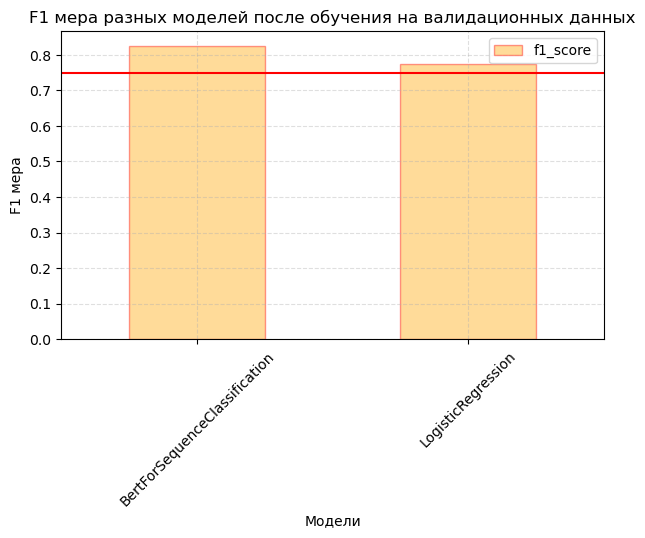

In [35]:
# График результатов обучения моделей 
ax = result.plot(kind='bar', x='model', y='f1_score', alpha=0.4, color='orange', ec='red', figsize=(7,4))
ax.axhline(POROG_TEST, color='red')
plt.grid(linestyle='--', alpha=0.4)
plt.title('F1 мера разных моделей после обучения на валидационных данных', fontsize=12) 
plt.xlabel('Модели', fontsize=10) 
plt.ylabel('F1 мера', fontsize=10) 
plt.xticks(rotation=45, fontsize=10)
plt.show()


### Вывод  

Сравнили результаты обучения: модель BertForSequenceClassification показала более высокую F1 метрику, чем модель LogisticRegression, однако скорость обучения модели BertForSequenceClassification при этом в несколько раз вые, чем у модели LogisticRegression

Можно сделать вывод, что модель BertForSequenceClassification лучше справляется с задачей классификации тональности твитов, чем модель LogisticRegression. BertForSequenceClassification обучается на больших объемах текстовых данных, что позволяет ей выучивать более сложные зависимости между словами и контекстом в тексте, что полезно для анализа тональности, так как многие слова и выражения могут иметь неочевидную тональность, которую модель должна учитывать. 

Поэтому для тестирования была выбрана BertForSequenceClassification.

## Тестирование модели

In [36]:
# Оценка модели на тестовой выборке

model.eval()
test_correct = 0
test_loss = 0
test_preds = []
test_labels = []
with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataloader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss
        test_loss += loss.item()
        preds = torch.argmax(logits, axis=1)
        test_correct += sum(preds == labels)
        test_preds.extend(preds.tolist())
        test_labels.extend(labels.tolist())

test_f1 = f1_score(test_labels, test_preds)    
test_accuracy = test_correct / len(test_dataset)
print(f"test loss: {test_loss / len(test_dataloader):.4f} | test accuracy: {test_accuracy:.4f}, test_F1: {test_f1:.4f}")  
    

test loss: 0.0936 | test accuracy: 0.9643, test_F1: 0.8204


### Проверка на критерий заказчика

In [37]:
[[print(f"Модель {result_bert.loc[0,'model']}  \n c гиперпараметрами {result_bert.loc[0,'best_params']}",
f"\n и качеством метрики f1 = {result_bert.loc[0,'f1_score']} \n прошла порогове значение заказчика f1={POROG_TEST}")]
 if (result_bert.loc[0,'f1_score'] > POROG_TEST)
 else print(f"Модель {result_bert.loc[0,'model']}",  
  f" и качеством метрики f1 = {result_bert.loc[0,'f1_score']} не прошла порогове значение заказчика f1={POROG_TEST}") 
]

Модель BertForSequenceClassification  
 c гиперпараметрами {'lr': 1e-05, 'epochs': 2} 
 и качеством метрики f1 = 0.825 
 прошла порогове значение заказчика f1=0.75


[[None]]

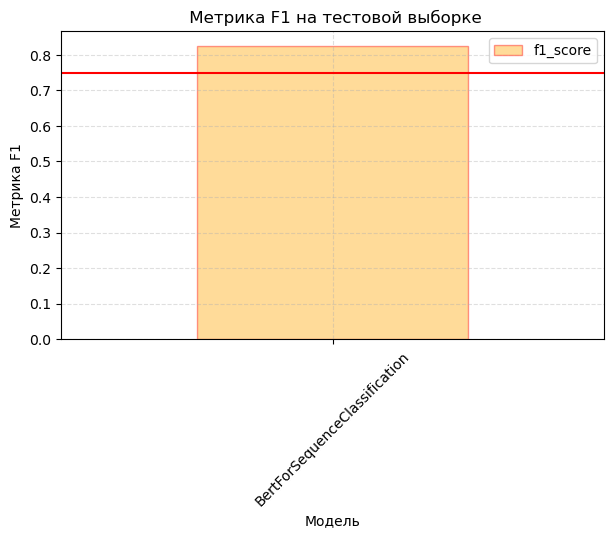

In [38]:
# График F1 метрики лучшей модели
ax = result_bert.plot(kind='bar', alpha=0.4, color='orange', ec='red', figsize=(7,4))
ax.set_xticks(range(len(result_bert)))
ax.set_xticklabels(result_bert['model'], rotation=45, fontsize=10)
ax.axhline(POROG_TEST, color='Red')
plt.grid(linestyle='--', alpha=0.4)
plt.title(f' Метрика F1 на тестовой выборке', fontsize=12) 
plt.xlabel('Модель', fontsize=10) 
plt.ylabel(f'Метрика F1', fontsize=10) 
plt.show()

## Общий вывод:

Изучены данные: 159292 количество строк - твитов, 3 колонки.  
Есть неинформативная колонка.  
Явных дубликатов и пропусков нет.  
Типы данных соответствуют содержанию.  

В данных присутствуют разные символы:  
В корпусе текстов содержится много символов не являющимися словами,  
знаки препинания, пробелы, многоточия, @, \n , символы разных кодировок, управляющие символы и тд.

Предобработали данные:
 - отфильтровали неинформативную колонку Unnamed 
 - подготовили наш корпус текстов:
 
 1. удалены ссылки и упоминания (@username)
 2. удалены знаки препинания и специальные символы
 3. удалены URL
 4. приведены всех буквы к нижнему регистру
 5. токенизированы тексты
 6. удалены стоп-слова
 7. проведена лемматизация 

   Количество слов в необработанном тексте квантиль 75% =  76 , после предобработки текстов 75% квантиль длиной  - 38 слова.  
   
    Мы почти в двое сократили количество слов в текстах, оставили только значимые, что хорошо скажется на результатах обучения, т.е. можно ограничить токенизатор Bert к близкому этому значению, это еще и увеличит скорость обучения без значимого ухудшения результатов.   
    
    
 Были обучены 2 модели LogisticRegression с разными гиперпараметрами и BertForSequenceClassification.  
 
Модель **LogisticRegression** была обучена с помощью оптимизатора параметров RandomizedSearchCV, который выбрал модель с лучшими гиперпараметрами по заданной заказчиком метрике    

**f1: 0.77**,   
**параметры лучшей модели  
{'clf__max_iter': 100, 'clf__C': 50}**


Модель **BertForSequenceClassification** была обучена  
**с гиперпараметрами: {'lr': 1e-05, 'epochs': 2}**  

Получено хорошее качество **f1 меры модели  0.83**,  
однако обучение заняло достаточно много времени.  

    
 Сравнили результаты обучения: модель BertForSequenceClassification показала более высокую F1 метрику, чем модель LogisticRegression, однако скорость обучения модели BertForSequenceClassification при этом в несколько раз выше, чем у модели LogisticRegression

Можно сделать вывод, что модель BertForSequenceClassification лучше справляется с задачей классификации тональности твитов, чем модель LogisticRegression. BertForSequenceClassification обучается на больших объемах текстовых данных, что позволяет ей выучивать более сложные зависимости между словами и контекстом в тексте, что полезно для анализа тональности, так как многие слова и выражения могут иметь неочевидную тональность, которую модель должна учитывать. 

Поэтому для тестирования была выбрана BertForSequenceClassification.
 
 **В результате тестирования модель показала значение качества f1 0.82, которое удовлетворяет критерию заказчика f1 более 0.75.**  
 
 
Следовательно, **заказчику рекомендуем использовать модель BertForSequenceClassification**, которая является более предпочтительным выбором для анализа тональности твитов, так как она может достичь более высокой меры качества f1 при классификации. При этом стоит отметить, что модель BertForSequenceClassification требует значительных вычислительных ресурсов и времени для обучения.